# Milestone 2: baseline models
___

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models
from importlib import reload
reload(import_preprocess)
reload(baseline_models)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, RuleBasedClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

In [24]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


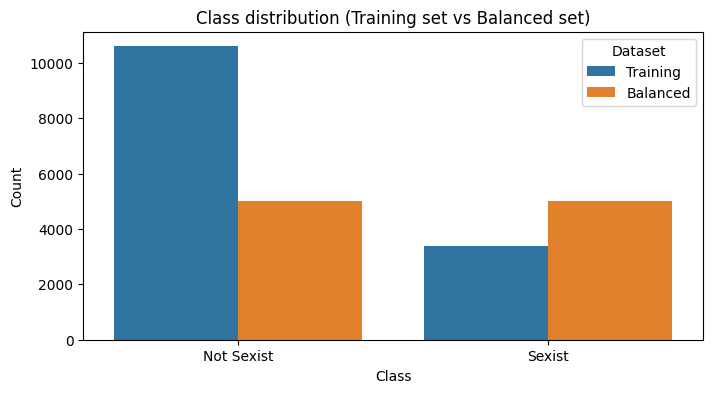

In [25]:
plot_data = pd.DataFrame({
    'Class': ['Not Sexist', 'Sexist'],
    'Training': [y_train.count('not sexist'), y_train.count('sexist')],
    'Balanced': [y_balanced.count('not sexist'), y_balanced.count('sexist')]
})
plot_data_melted = plot_data.melt(id_vars='Class', var_name='Dataset', value_name='Count')
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_data_melted)
plt.title('Class distribution (Training set vs Balanced set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [26]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



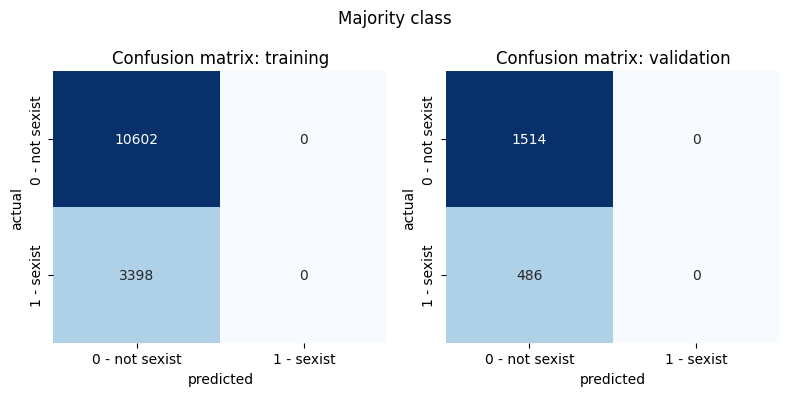

In [27]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="Majority class")
for res_x in res:
    results.loc[len(results)] = res_x

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.5000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



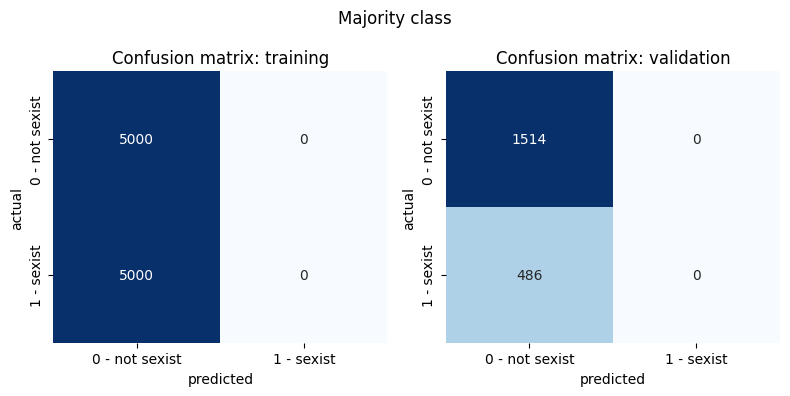

In [28]:
majority_class_classifier_bal = MajorityClassClassifier()
majority_class_classifier_bal.train(None, y_balanced, None, None)
print(f"Majority class: {majority_class_classifier_bal.majority_class}\n")

res = majority_class_classifier_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="Majority class")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

2. regex classifier (rule-based)

########################################

Metrics for training
accuracy: 0.7164
balanced accuracy: 0.5732
precision: 0.3890
recall: 0.2949

########################################

Metrics for validation
accuracy: 0.7075
balanced accuracy: 0.5630
precision: 0.3673
recall: 0.2819

########################################



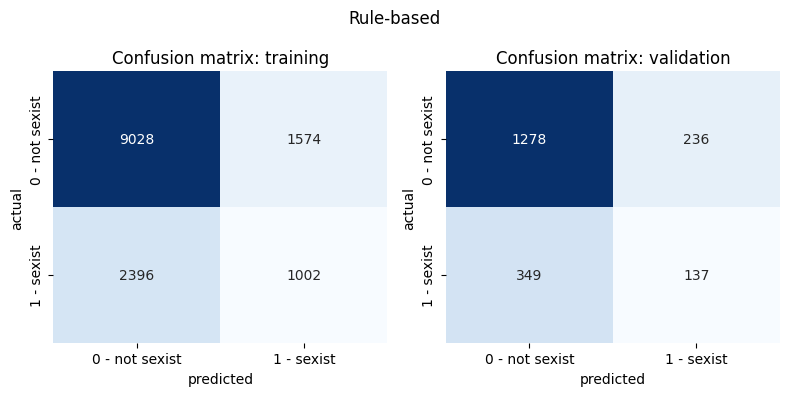

In [29]:
patterns = [
    r"\b(slut|bitch|fuck|fucking|sex)\b",
    r"\b(she has|she has to|she must|she shouldn't|women have to|women must|women shouldn't)\b",
    r"\b(hate|die)\b"
]

regex_classifier = RuleBasedClassifier(patterns)
res = regex_classifier.evaluate({"training": S_train, "validation": S_val}, [y_train, y_val], model_name="Rule-based")
for res_x in res:
    results.loc[len(results)] = res_x

3. Naive Bayes (NB)

########################################

Metrics for training
accuracy: 0.8617
balanced accuracy: 0.7936
precision: 0.7411
recall: 0.6613

########################################

Metrics for validation
accuracy: 0.8095
balanced accuracy: 0.7128
precision: 0.6296
recall: 0.5247

########################################



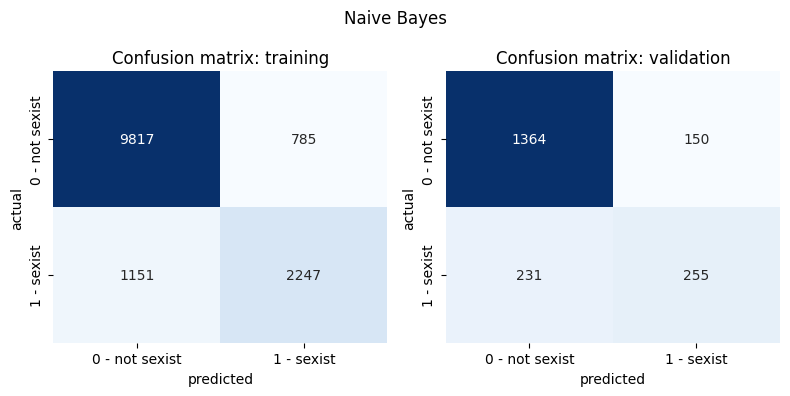

In [30]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x

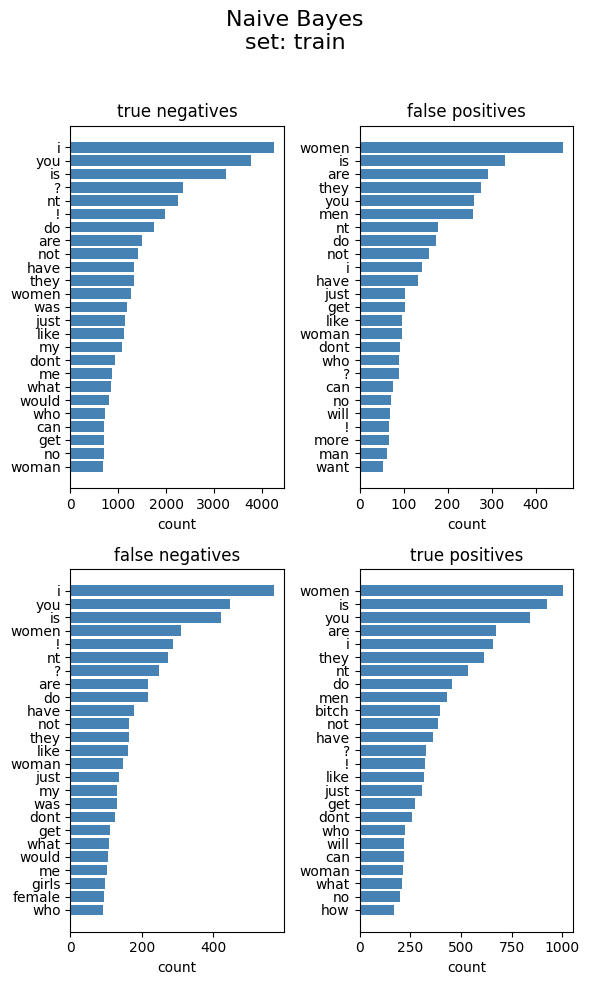

In [31]:
naive_bayes_classifier.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

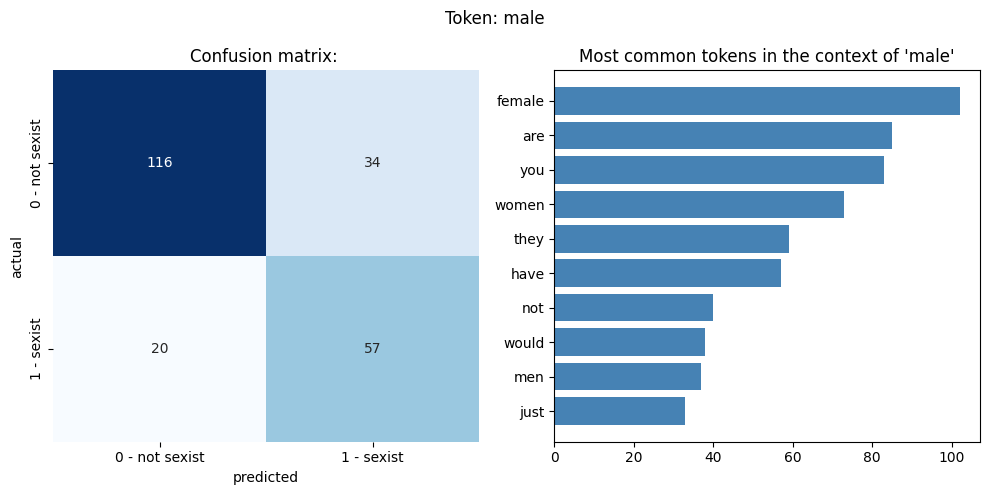

Examples:
Label: not sexist, Prediction: not sexist
Know that quote about the universe and human stupidity being infinite? Let's add male audacity to it.

Label: not sexist, Prediction: not sexist
"If you play games you're a nu male". I'm female and I love games. Always have. Why do you sound like Anita Sarkeesian?

Label: not sexist, Prediction: not sexist
âhotdogâ = boy âpizzaâ = girl âcheeseâ = little girl âpastaâ = little boy âice creamâ = male prostitute âwalnutâ = person of colour âmapâ = semen âsauceâ = orgy #PedoWood #PizzaGate #PedoGate [URL]

Label: sexist, Prediction: sexist
Imagine thinking of sports as nothing more than a blue collar job and that male and female athletes are "doing the same job," so they deserve the same pay. That's female logic right there.

Label: sexist, Prediction: sexist
Biologically programmed to search out best male breeding stock, unapologetic about her behaviour. Pure feral. Her morality has reverted to primal insti

In [32]:
naive_bayes_classifier.get_context_for_token("male", X_train_bow, y_train, X_train, S_train, no_examples=5, return_contexts=False)

In [33]:
top_tn_tokens, top_fp_tokens, top_fn_tokens, top_tp_tokens = \
    naive_bayes_classifier.qualitative_analysis_top_tokens(
        X_train, X_train_bow, y_train, set_type="train", 
        model_name="Naive Bayes", plot=False, top_n=50)

########################################

Metrics for training
accuracy: 0.8342
balanced accuracy: 0.8342
precision: 0.8218
recall: 0.8534

########################################

Metrics for validation
accuracy: 0.7310
balanced accuracy: 0.7064
precision: 0.4624
recall: 0.6584

########################################



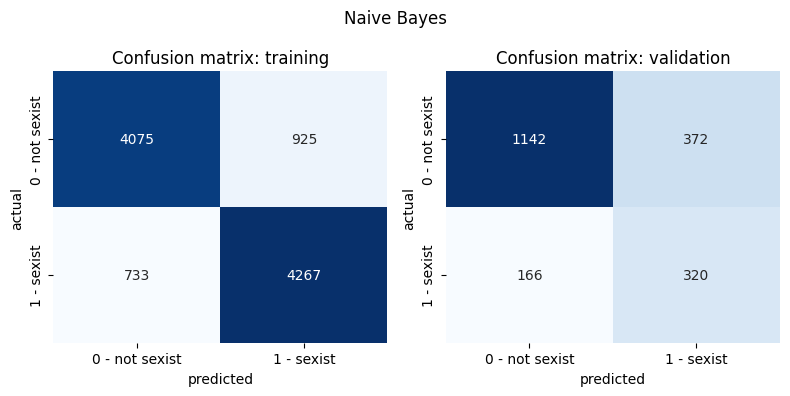

In [34]:
X_train_balanced_bow, X_val_balanced_bow, X_test_balanced_bow, X_train_val_balanced_bow, feature_names = import_preprocess.create_bow_representation(balanced=True)

naive_bayes_classifier_bal = NaiveBayesClassifier()
naive_bayes_classifier_bal.train(X_train_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

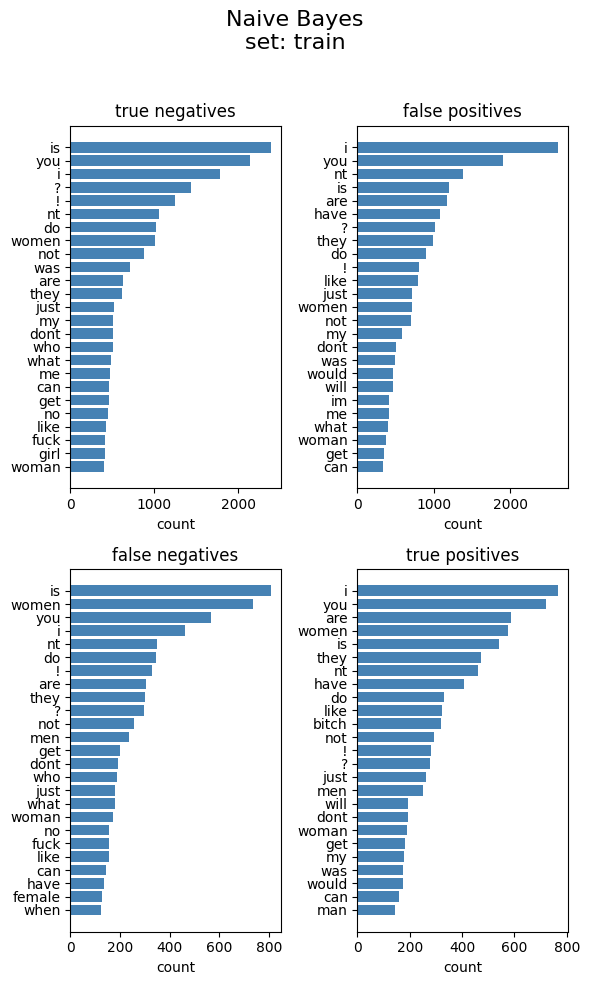

In [35]:
naive_bayes_classifier_bal.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

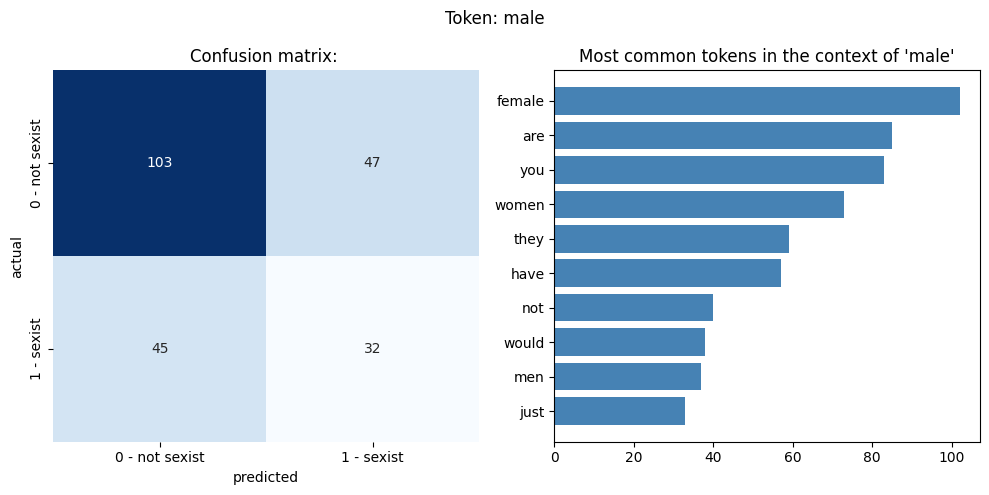

Examples:
Label: not sexist, Prediction: sexist
I don't think there are many white females going to Asia to teach English. There are a ton of horny male sexpats though.

Label: not sexist, Prediction: not sexist
I mean guys I ain't got lie it was my fantasy as a middle schooler. So yea but both male and female taking advantage of kids are bad.

Label: not sexist, Prediction: not sexist
Right. It has to come down to a measurement at some point. That's what feminists tend to claim is anti woman. They claim that measuring by the "bottom line" is male oriented.

Label: sexist, Prediction: not sexist
You first ask a female do define male privalage before bombarding her with facts. You can easily debunk anything a feminist claims. Same goes when asking her to justify feminism or female rights.

Label: sexist, Prediction: not sexist
Imagine the hellfire if a male senator said that about women.



In [36]:
naive_bayes_classifier_bal.get_context_for_token("male", X_train_bow, y_train, X_train, S_train, no_examples=5, return_contexts=False)

4. Logisitic Regression

########################################

Metrics for training
accuracy: 0.8935
balanced accuracy: 0.8059
precision: 0.8952
recall: 0.6357

########################################

Metrics for validation
accuracy: 0.8290
balanced accuracy: 0.7075
precision: 0.7293
recall: 0.4712

########################################



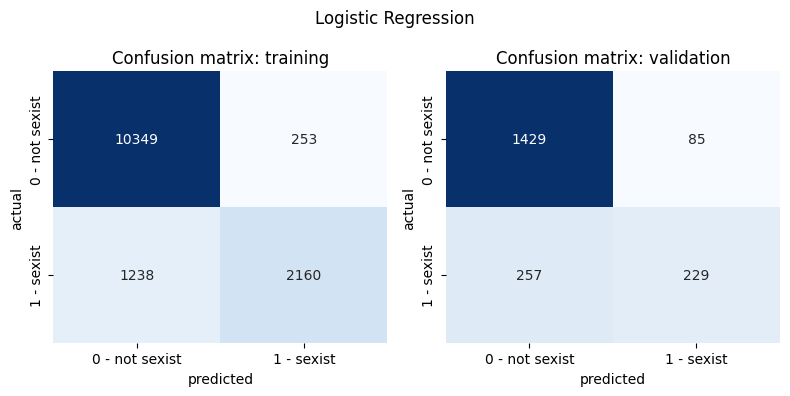

In [37]:
log_reg_classifier = LogisticRegression()
log_reg_classifier.train(X_train_bow, y_train, None, None)

res = log_reg_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Logistic Regression")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.9174
balanced accuracy: 0.9174
precision: 0.9270
recall: 0.9062

########################################

Metrics for validation
accuracy: 0.6870
balanced accuracy: 0.5264
precision: 0.2989
recall: 0.2140

########################################



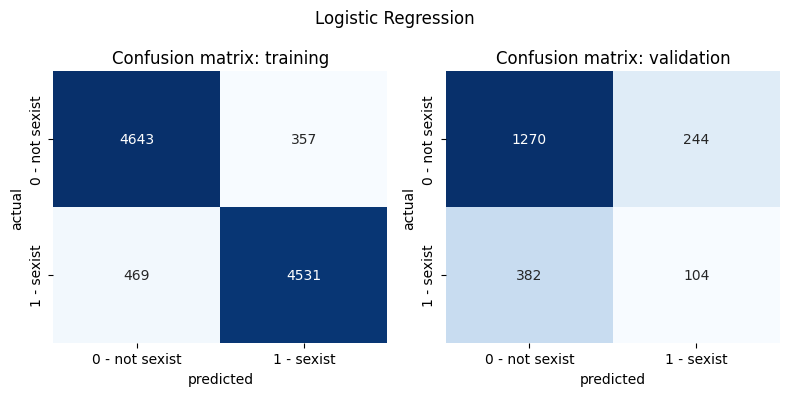

In [38]:
log_reg_classifier_bal = LogisticRegression()
log_reg_classifier_bal.train(X_train_balanced_bow, y_balanced, None, None)

res = log_reg_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Logistic Regression")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (using BoW representation)

[0]	train-logloss:0.52937	eval-logloss:0.53489
[1]	train-logloss:0.50975	eval-logloss:0.51887
[2]	train-logloss:0.49416	eval-logloss:0.50663
[3]	train-logloss:0.48118	eval-logloss:0.49671
[4]	train-logloss:0.46993	eval-logloss:0.48862
[5]	train-logloss:0.46076	eval-logloss:0.48167
[6]	train-logloss:0.45330	eval-logloss:0.47543
[7]	train-logloss:0.44617	eval-logloss:0.47048
[8]	train-logloss:0.44011	eval-logloss:0.46656
[9]	train-logloss:0.43457	eval-logloss:0.46248
[10]	train-logloss:0.43010	eval-logloss:0.45932
[11]	train-logloss:0.42573	eval-logloss:0.45708
[12]	train-logloss:0.42207	eval-logloss:0.45470
[13]	train-logloss:0.41817	eval-logloss:0.45220
[14]	train-logloss:0.41501	eval-logloss:0.44986
[15]	train-logloss:0.41222	eval-logloss:0.44831
[16]	train-logloss:0.40954	eval-logloss:0.44615
[17]	train-logloss:0.40690	eval-logloss:0.44448
[18]	train-logloss:0.40493	eval-logloss:0.44312
[19]	train-logloss:0.40277	eval-logloss:0.44169
[20]	train-logloss:0.40112	eval-logloss:0.43993
[2

c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	train-logloss:0.38499	eval-logloss:0.43031
[30]	train-logloss:0.38381	eval-logloss:0.42932
[31]	train-logloss:0.38274	eval-logloss:0.42861
[32]	train-logloss:0.38153	eval-logloss:0.42811
[33]	train-logloss:0.37980	eval-logloss:0.42770
[34]	train-logloss:0.37830	eval-logloss:0.42676
[35]	train-logloss:0.37740	eval-logloss:0.42628
[36]	train-logloss:0.37658	eval-logloss:0.42558
[37]	train-logloss:0.37467	eval-logloss:0.42524
[38]	train-logloss:0.37381	eval-logloss:0.42466
[39]	train-logloss:0.37282	eval-logloss:0.42395
[40]	train-logloss:0.37130	eval-logloss:0.42349
[41]	train-logloss:0.37018	eval-logloss:0.42304
[42]	train-logloss:0.36854	eval-logloss:0.42206
[43]	train-logloss:0.36748	eval-logloss:0.42170
[44]	train-logloss:0.36660	eval-logloss:0.42121
[45]	train-logloss:0.36559	eval-logloss:0.42051
[46]	train-logloss:0.36492	eval-logloss:0.41985
[47]	train-logloss:0.36416	eval-logloss:0.41922
[48]	train-logloss:0.36326	eval-logloss:0.41879
[49]	train-logloss:0.36226	eval-logloss:

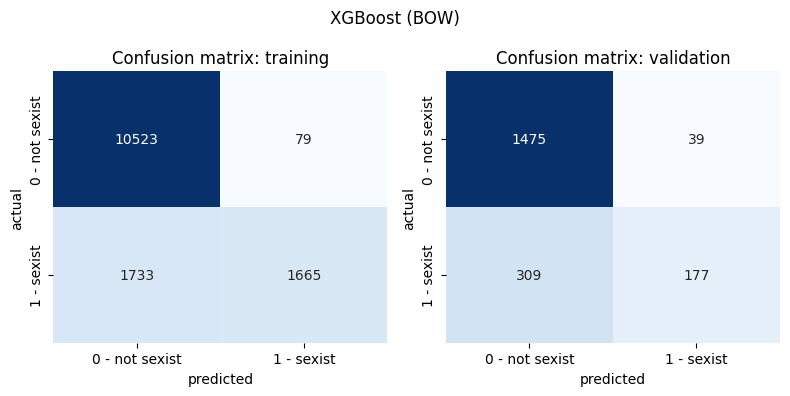

In [39]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66678	eval-logloss:0.67049
[1]	train-logloss:0.64531	eval-logloss:0.65176
[2]	train-logloss:0.62742	eval-logloss:0.63623
[3]	train-logloss:0.61250	eval-logloss:0.62282
[4]	train-logloss:0.59967	eval-logloss:0.61170
[5]	train-logloss:0.58817	eval-logloss:0.60186
[6]	train-logloss:0.57868	eval-logloss:0.59315
[7]	train-logloss:0.56978	eval-logloss:0.58617
[8]	train-logloss:0.56202	eval-logloss:0.57998
[9]	train-logloss:0.55500	eval-logloss:0.57377
[10]	train-logloss:0.54876	eval-logloss:0.56855
[11]	train-logloss:0.54332	eval-logloss:0.56413
[12]	train-logloss:0.53817	eval-logloss:0.55929
[13]	train-logloss:0.53373	eval-logloss:0.55551
[14]	train-logloss:0.52916	eval-logloss:0.55206
[15]	train-logloss:0.52455	eval-logloss:0.54909
[16]	train-logloss:0.52099	eval-logloss:0.54540
[17]	train-logloss:0.51819	eval-logloss:0.54274
[18]	train-logloss:0.51454	eval-logloss:0.54099
[19]	train-logloss:0.51201	eval-logloss:0.53837
[20]	train-logloss:0.50892	eval-logloss:0.53648
[2

c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	train-logloss:0.47361	eval-logloss:0.51194
[38]	train-logloss:0.47172	eval-logloss:0.51106
[39]	train-logloss:0.47032	eval-logloss:0.51044
[40]	train-logloss:0.46900	eval-logloss:0.50956
[41]	train-logloss:0.46743	eval-logloss:0.50880
[42]	train-logloss:0.46628	eval-logloss:0.50794
[43]	train-logloss:0.46500	eval-logloss:0.50723
[44]	train-logloss:0.46351	eval-logloss:0.50671
[45]	train-logloss:0.46250	eval-logloss:0.50604
[46]	train-logloss:0.46091	eval-logloss:0.50532
[47]	train-logloss:0.45850	eval-logloss:0.50420
[48]	train-logloss:0.45743	eval-logloss:0.50343
[49]	train-logloss:0.45631	eval-logloss:0.50307
[50]	train-logloss:0.45460	eval-logloss:0.50196
[51]	train-logloss:0.45328	eval-logloss:0.50118
[52]	train-logloss:0.45228	eval-logloss:0.50046
[53]	train-logloss:0.44916	eval-logloss:0.49944
[54]	train-logloss:0.44827	eval-logloss:0.49894
[55]	train-logloss:0.44742	eval-logloss:0.49845
[56]	train-logloss:0.44635	eval-logloss:0.49794
[57]	train-logloss:0.44537	eval-logloss:

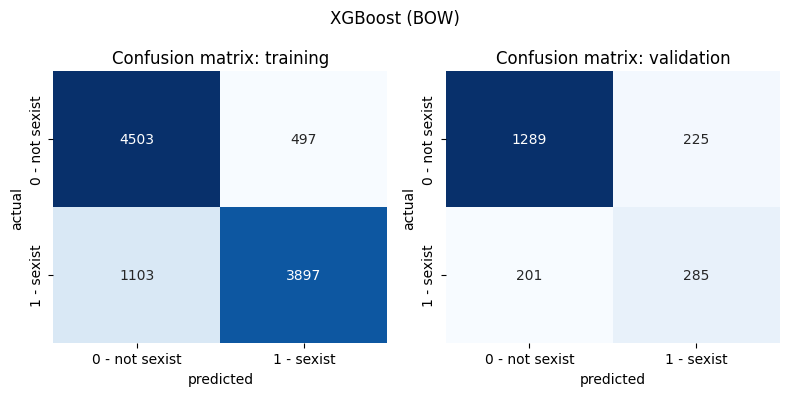

In [40]:
xg_boost_bow_bal = XGBoostClassifier()
xg_boost_bow_bal.train(X_train_balanced_bow, y_balanced, X_val_balanced_bow, y_val)

res = xg_boost_bow_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (TF-IDF representation)

c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.52895	eval-logloss:0.53464
[1]	train-logloss:0.50881	eval-logloss:0.51849
[2]	train-logloss:0.49230	eval-logloss:0.50607
[3]	train-logloss:0.47871	eval-logloss:0.49626
[4]	train-logloss:0.46732	eval-logloss:0.48821
[5]	train-logloss:0.45755	eval-logloss:0.48143
[6]	train-logloss:0.44971	eval-logloss:0.47591
[7]	train-logloss:0.44228	eval-logloss:0.47149
[8]	train-logloss:0.43529	eval-logloss:0.46698
[9]	train-logloss:0.42959	eval-logloss:0.46330
[10]	train-logloss:0.42450	eval-logloss:0.46053
[11]	train-logloss:0.42004	eval-logloss:0.45817
[12]	train-logloss:0.41591	eval-logloss:0.45579
[13]	train-logloss:0.41196	eval-logloss:0.45377
[14]	train-logloss:0.40790	eval-logloss:0.45150
[15]	train-logloss:0.40478	eval-logloss:0.44956
[16]	train-logloss:0.40170	eval-logloss:0.44840
[17]	train-logloss:0.39922	eval-logloss:0.44633
[18]	train-logloss:0.39656	eval-logloss:0.44510
[19]	train-logloss:0.39369	eval-logloss:0.44414
[20]	train-logloss:0.39111	eval-logloss:0.44330
[2

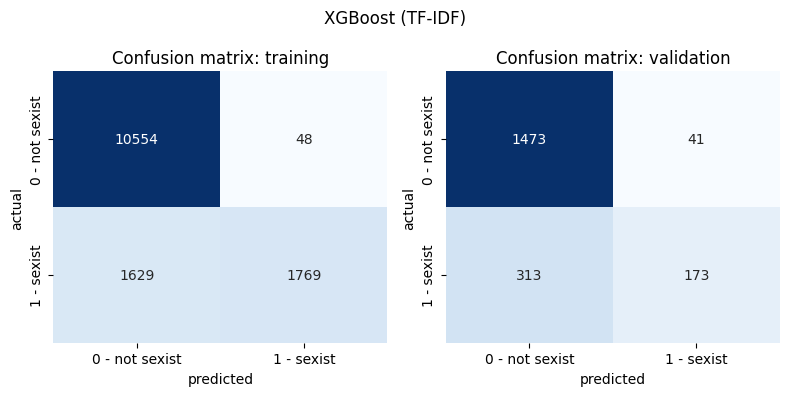

In [41]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, X_train_val_tfidf, feature_names = import_preprocess.create_tfidf_representation()

xg_boost_tfidf = XGBoostClassifier()
xg_boost_tfidf.train(X_train_tfidf, y_train, X_val_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_tfidf, "validation": X_val_tfidf}, [y_train, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66602	eval-logloss:0.67070


c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-logloss:0.64369	eval-logloss:0.65173
[2]	train-logloss:0.62532	eval-logloss:0.63591
[3]	train-logloss:0.60920	eval-logloss:0.62208
[4]	train-logloss:0.59536	eval-logloss:0.61063
[5]	train-logloss:0.58334	eval-logloss:0.60120
[6]	train-logloss:0.57328	eval-logloss:0.59260
[7]	train-logloss:0.56292	eval-logloss:0.58427
[8]	train-logloss:0.55499	eval-logloss:0.57766
[9]	train-logloss:0.54735	eval-logloss:0.57188
[10]	train-logloss:0.54107	eval-logloss:0.56615
[11]	train-logloss:0.53483	eval-logloss:0.56139
[12]	train-logloss:0.52917	eval-logloss:0.55710
[13]	train-logloss:0.52359	eval-logloss:0.55270
[14]	train-logloss:0.51914	eval-logloss:0.54993
[15]	train-logloss:0.51462	eval-logloss:0.54648
[16]	train-logloss:0.50946	eval-logloss:0.54400
[17]	train-logloss:0.50638	eval-logloss:0.54109
[18]	train-logloss:0.50287	eval-logloss:0.53907
[19]	train-logloss:0.49992	eval-logloss:0.53695
[20]	train-logloss:0.49627	eval-logloss:0.53494
[21]	train-logloss:0.49378	eval-logloss:0.53270
[

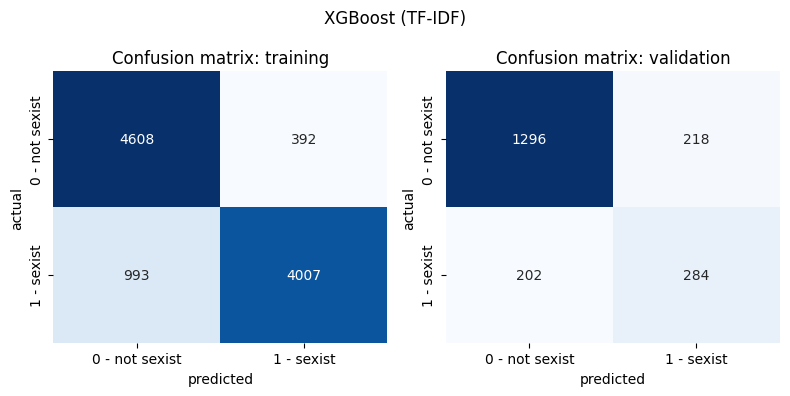

In [42]:
X_train_balanced_tfidf, X_val_balanced_tfidf, X_test_balanced_tfidf, X_train_val_balanced_tfidf, feature_names = import_preprocess.create_tfidf_representation(balanced=True)

xg_boost_tfidf_bal = XGBoostClassifier()
xg_boost_tfidf_bal.train(X_train_balanced_tfidf, y_balanced, X_val_balanced_tfidf, y_val)

res = xg_boost_tfidf_bal.evaluate({"training": X_train_balanced_tfidf, "validation": X_val_balanced_tfidf}, [y_balanced, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

#### b) DL baseline models

1. LSTM

In [43]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

Epoch 1/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7532 - loss: 0.5662 - val_accuracy: 0.7565 - val_loss: 0.5604
Epoch 2/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7563 - loss: 0.5558 - val_accuracy: 0.7570 - val_loss: 0.5319
Epoch 3/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7622 - loss: 0.5228 - val_accuracy: 0.7690 - val_loss: 0.5291
Epoch 4/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7740 - loss: 0.5221 - val_accuracy: 0.7660 - val_loss: 0.5362
Epoch 5/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7818 - loss: 0.5204 - val_accuracy: 0.7570 - val_loss: 0.5285
Epoch 6/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7618 - loss: 0.5079 - val_accuracy: 0.7570 - val_loss: 0.5355
Epoch 7/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7561 - loss: 0.5167 - val_accuracy: 0.6540 - val_loss: 0.5717
Epoch 8/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7780 - loss: 0.4698 - 

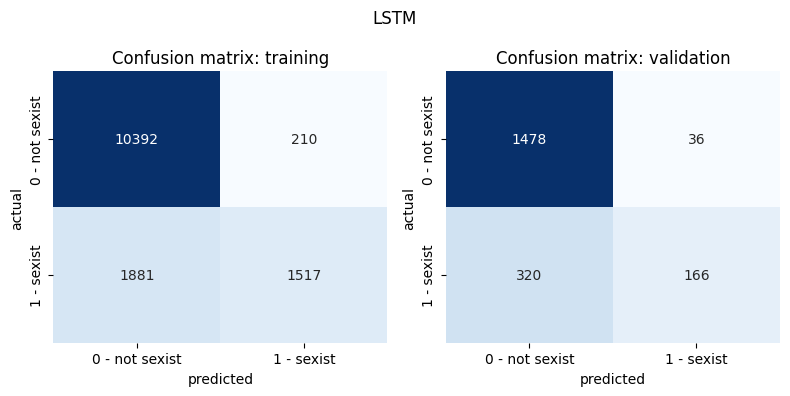

In [44]:
rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


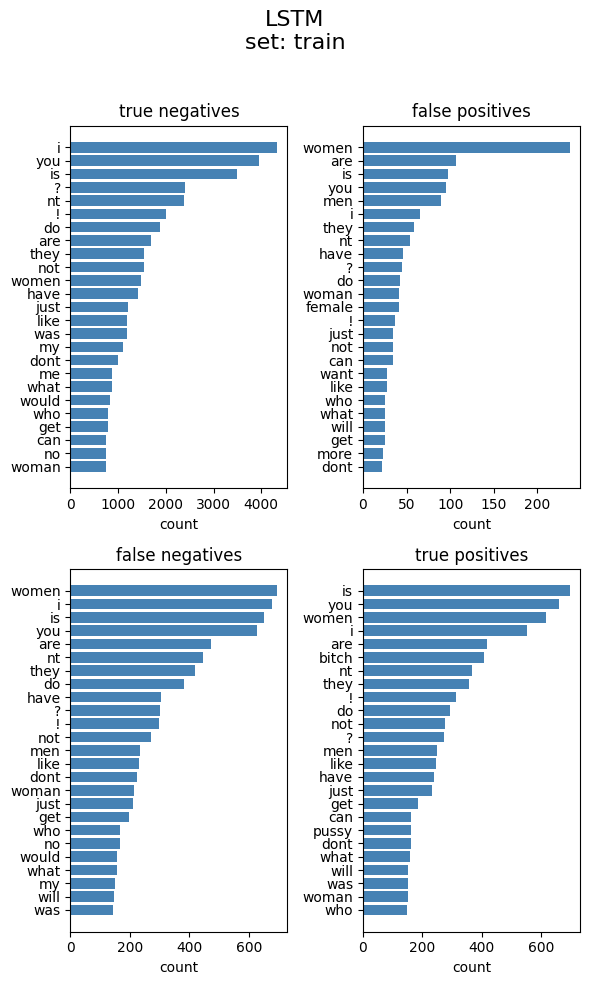

In [45]:
rnn.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


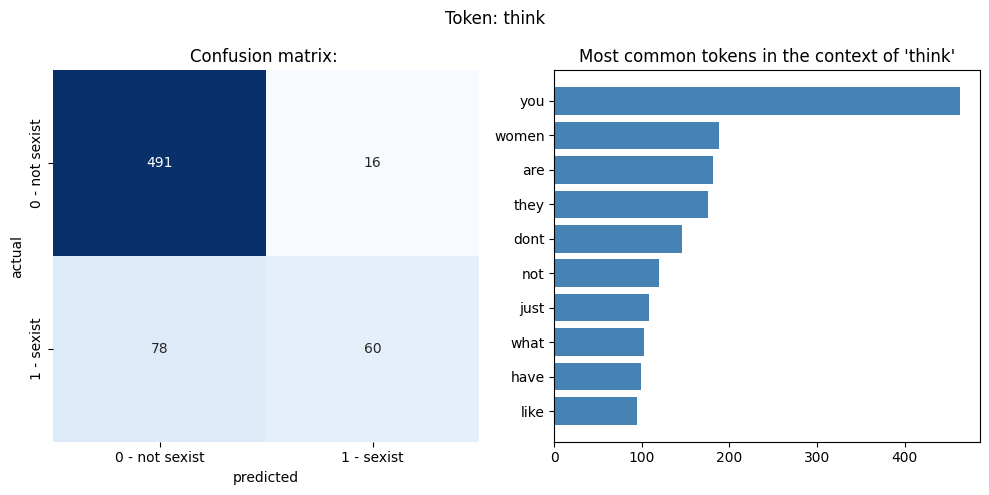

Examples:
Label: sexist, Prediction: [0]
[USER] [USER] I think her full Indian name is something like She Who Lies Like B*tch

Label: not sexist, Prediction: [0]
My wife has agreed to go through confirmation. Weâre a bit reluctant to home school but we think Catholic school will provide our kids with education, society, and humility.

Label: not sexist, Prediction: [0]
I don't think she would be able to swing a .50 cal as well as a GLOCK or S&W

Label: not sexist, Prediction: [0]
Oooooh I don't think I could do that. I don't think I could avoid trying to sleep with my made up pen name seeing as it's a Chad or Tyrone lol.

Label: not sexist, Prediction: [0]
Tfw your girlfriend has a higher libido than you and wonder how anyone would be down for sex at anytime, like Jesus I got a lot of shit to do before I even have time to think about sticking my penis into a consenting orifice



In [46]:
rnn.get_context_for_token("think", X_train, y_train, X_train, S_train, no_examples=5, return_contexts=False)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4973 - loss: 0.6937 - val_accuracy: 0.2435 - val_loss: 0.6944
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4962 - loss: 0.6934 - val_accuracy: 0.2435 - val_loss: 0.6963
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4991 - loss: 0.6933 - val_accuracy: 0.2435 - val_loss: 0.6945
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4904 - loss: 0.6933 - val_accuracy: 0.7570 - val_loss: 0.6879
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4988 - loss: 0.6933 - val_accuracy: 0.7570 - val_loss: 0.6881
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5023 - loss: 0.6932 - val_accuracy: 0.3290 - val_loss: 0.6953
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5307 - loss: 0.6908 - val_accuracy: 0.7555 - val_loss: 0.6176
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5912 - loss: 0.6698 - 

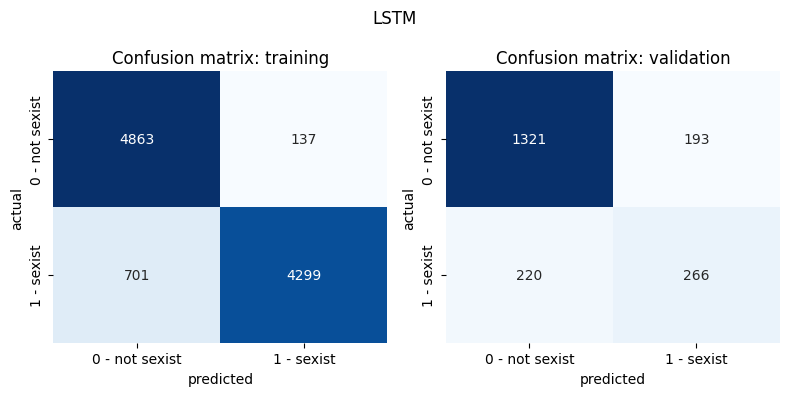

In [47]:
rnn_bal = LSTM_Model()
rnn_bal.train(X_balanced, y_balanced, X_val, y_val)
res = rnn_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


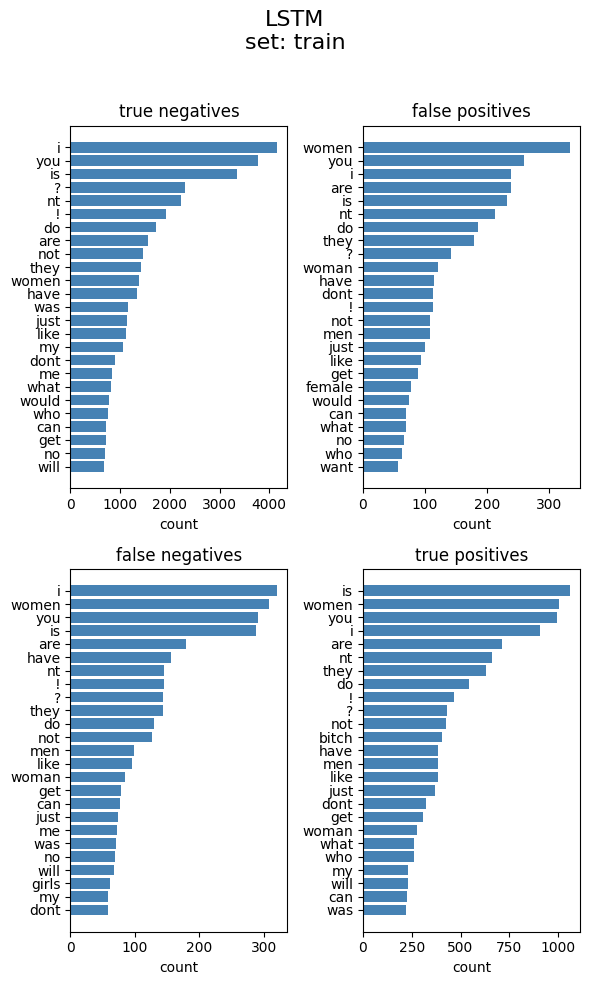

In [48]:
rnn_bal.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


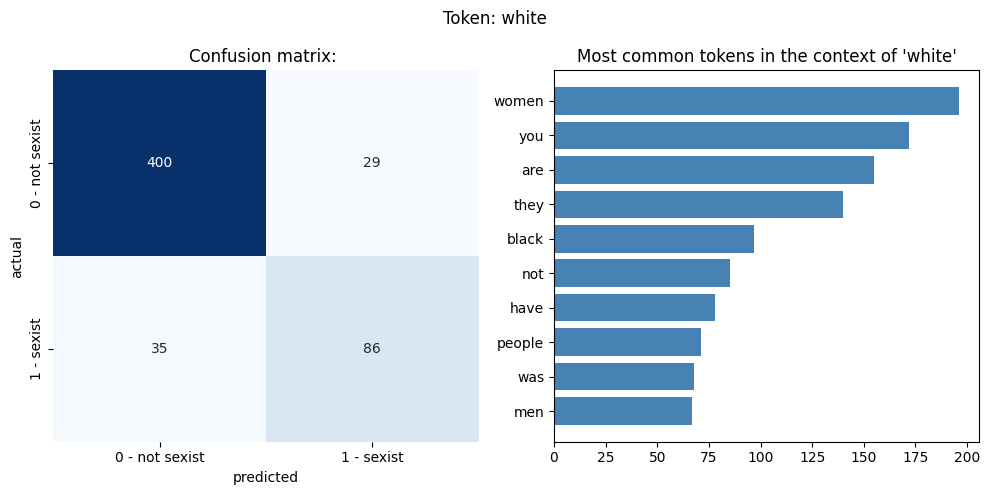

Examples:
Label: sexist, Prediction: [1]
Niggere be niggin. Its dey way. He dindo nuffin wrong, he jus be lookin fo some money, he owed shit cause ah dat opressions. dat bitch try an stop homie she gots wat she deserved. All he do is rape her an kill a white. Dis is cause he black.

Label: not sexist, Prediction: [0]
Iâm just saying Iâve fucked like 4 white chicks lol , only 1 asian well 2 if you count half white half Asian . My point is I can get white girls (Iâm not an incel but I want pointers / advice)

Label: not sexist, Prediction: [0]
I'm not disputing that- especially shit about why Africa is as fucked as it is. I'm just trying to explain to this kid that it's not the average Joe white man keeping blacks down.

Label: sexist, Prediction: [0]
No, I'm black actually. Go ahead, check my post history to confirm it lol Classic incel tears. Most incels aren't white, white is a *desirable* trait for women.

Label: not sexist, Prediction: [0]
Why do you hate your own sex? I reall

In [49]:
rnn_bal.get_context_for_token("white", X_train, y_train, X_train, S_train, no_examples=5, return_contexts=False)

## Results

In [50]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.757286,0.500000,0.000000,0.000000
1,Majority class,validation,0.757000,0.500000,0.000000,0.000000
2,Rule-based,training,0.716429,0.573208,0.388975,0.294879
3,Rule-based,validation,0.707500,0.563007,0.367292,0.281893
4,Naive Bayes,training,0.861714,0.793614,0.741095,0.661271
5,Naive Bayes,validation,0.809500,0.712808,0.629630,0.524691
6,Logistic Regression,training,0.893500,0.805902,0.895151,0.635668
7,Logistic Regression,validation,0.829000,0.707525,0.729299,0.471193
8,XGBoost (BOW),training,0.870571,0.741271,0.954702,0.489994
9,XGBoost (BOW),validation,0.826000,0.669219,0.819444,0.364198


In [51]:
balanced_results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.5000,0.500000,0.000000,0.000000
1,Majority class,validation,0.7570,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.8342,0.834200,0.821841,0.853400
3,Naive Bayes,validation,0.7310,0.706365,0.462428,0.658436
4,Logistic Regression,training,0.9174,0.917400,0.926964,0.906200
5,Logistic Regression,validation,0.6870,0.526415,0.298851,0.213992
6,XGBoost (BOW),training,0.8400,0.840000,0.886891,0.779400
7,XGBoost (BOW),validation,0.7870,0.718903,0.558824,0.586420
8,XGBoost (TF-IDF),training,0.8615,0.861500,0.910889,0.801400
9,XGBoost (TF-IDF),validation,0.7900,0.720186,0.565737,0.584362


In [52]:
models_dict = {
    "Majority Class": majority_class_classifier,
    "Naive Bayes": naive_bayes_classifier,
    "Logistic Regression": log_reg_classifier,
    "XGBoost (BOW)": xg_boost_bow,
    "LSTM": rnn
}

predictions = get_all_predictions(models_dict, X_val[1], X_val_bow[1], y_val[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [53]:
predictions

{'true': 'not sexist',
 'Majority Class': ['not sexist'],
 'Naive Bayes': array(['not sexist'], dtype='<U10'),
 'Logistic Regression': array(['not sexist'], dtype='<U10'),
 'XGBoost (BOW)': ['not sexist'],
 'LSTM': 'not sexist'}

In [54]:
y_pred = rnn.predict(X_val)
y_pred = convert_labels_to_string(y_pred)
y_val = y_val if isinstance(y_val[0], str) else convert_labels_to_string(y_val)

false_negative_indices = [i for i in range(len(X_val)) if y_val[i] == 'sexist' and y_pred[i] == 'not sexist']
false_negative_sentences = [S_val[i] for i in false_negative_indices]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


# Report on Misclassification Analysis of RNN Model

In [55]:
import random
random.seed(1234)
# Predict on the test set
y_pred_test = rnn.predict(X_test)

# Convert predictions and true labels to string format
y_pred_test = convert_labels_to_string(y_pred_test)
y_test = y_test if isinstance(y_test[0], str) else convert_labels_to_string(y_test)

# Identify indices for each confusion matrix quadrant
tp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'sexist']  # True Positives
tn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'not sexist']  # True Negatives
fp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'sexist']  # False Positives
fn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'not sexist']  # False Negatives

# Randomly sample up to 25 sentences from each quadrant
sampled_tp_test = random.sample(tp_indices_test, min(200, len(tp_indices_test)))
sampled_tn_test = random.sample(tn_indices_test, min(200, len(tn_indices_test)))
sampled_fp_test = random.sample(fp_indices_test, min(200, len(fp_indices_test)))
sampled_fn_test = random.sample(fn_indices_test, min(200, len(fn_indices_test)))

# Extract sentences for sampled indices
sampled_sentences_tp_test = [S_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test = [S_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test = [S_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test = [S_test[i] for i in sampled_fn_test]

# Extract multi labels for sampled indices
sampled_sentences_tp_test_multi_label = [y_test_multi[i] for i in sampled_tp_test]
sampled_sentences_tn_test_multi_label = [y_test_multi[i] for i in sampled_tn_test]
sampled_sentences_fp_test_multi_label = [y_test_multi[i] for i in sampled_fp_test]
sampled_sentences_fn_test_multi_label = [y_test_multi[i] for i in sampled_fn_test]

# Extract labels for sampled indices
sampled_sentences_tp_test_label = [y_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test_label = [y_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test_label = [y_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test_label = [y_test[i] for i in sampled_fn_test]

tp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tp_test_multi_label, sampled_sentences_tp_test_label)])
tn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tn_test_multi_label, sampled_sentences_tn_test_label)])
fp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fp_test_multi_label, sampled_sentences_fp_test_label)])
fn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fn_test_multi_label, sampled_sentences_fn_test_label)])

# Print the sampled sentences for analysis
print(f"Sampled True Positives (TP), {tp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tp_test, sampled_sentences_tp_test_label, sampled_sentences_tp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled True Negatives (TN), {tn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tn_test, sampled_sentences_tn_test_label, sampled_sentences_tn_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Positives (FP), {fp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fp_test, sampled_sentences_fp_test_label, sampled_sentences_fp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Negatives (FN), {fn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fn_test, sampled_sentences_fn_test_label, sampled_sentences_fn_test_multi_label):
    print(s_y, s_y_multi, sentence)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sampled True Positives (TP), 196 samples in agreement:
sexist ['sexist', 'not sexist', 'not sexist'] oh jeez the fair pay thing is back...I guess next will be equality in schools or some shit women blax muzzeez wetbax, blax women muzzeez wetbax fags fags fags repeat
sexist ['sexist', 'sexist', 'sexist'] I don't care if that bitch blew Hitler himself and swallowed, she's still a piece of shit that deserves to hang for her endless crimes against humanity... after a trial of course..
sexist ['not sexist', 'sexist', 'sexist'] LOL that fat girl .... black men cant catch up to us so they are angry ..... sooo black men are angry because they are not marrying black women .... LOL bitch plz
sexist ['sexist', 'not sexist', 'not sexist'] I doubt it, its only because female pedophiles are rarely recognized as such. Hell, when a woman sleeps with a young boy its practically not even a crime, she gets a slap on the wrist and everyone says "nice".
sexist ['sex

## Overview
We are going into an in depth analysis of the RNN model's misclassifications on the test dataset for a sexism detection task. It categorizes the sentences into four confusion matrix quadrants:
- **True Positives (TP):** Correctly classified as sexist.
- **True Negatives (TN):** Correctly classified as not sexist.
- **False Positives (FP):** Incorrectly classified as sexist.
- **False Negatives (FN):** Incorrectly classified as not sexist.

With this analysis we identify patterns in the misclassified samples and suggests improvements to enhance the model's performance.

---

## True Positives (TP)

### **Characteristics:**
- These sentences contain overt sexism, including:
  - Explicit slurs (e.g., "cunt," "bitch," "whore").
  - Objectifying women (e.g., "like a walking dildo").
  - Hostility towards women in power or feminists (e.g., "Fuck this stupid woman").
  - Stereotypes of traditional gender roles (e.g., "Don’t let women vote").

### **Patterns:**
- Use of explicit misogynistic slurs.
- Contextual misogyny targeting gender roles or political affiliations.
- Common references to male-dominant ideologies like MGTOW.

### **Examples:**
- "The sad reality is without sex, men don’t need or want women. But women desire and crave male attention, that’s why they are constantly invading and taking over male spaces."
- "That ho is nothing but a cat's full little box throw her to the dump!"
- "Wow, cheating is so easy and natural for women, that even women in their 80s can do it."

---

## True Negatives (TN)

### **Characteristics:**
- These sentences do not contain sexism and were correctly identified as not sexist.
- They include:
  - Neutral personal reflections (e.g., "My life is filled with things I love: video games, soccer, backpacking trips").
  - Discussions about unrelated topics (e.g., "Quality? I don’t know about you but Cap’s gay ass little arm shields ruined it for me").
  - Sarcastic or humorous comments unrelated to sexism.

### **Patterns:**
- Neutral language and context unrelated to sexism.
- Sarcasm or humor that lacks hostile undertones.
- Discussions focusing on non gender related issues.

### **Examples:**
- "LOL, a Canadian guy legally changed his gender to female so that he would save $1000 a year on car insurance."
- "Normal and normal, girls just don't find me attractive."
- "She stopped responding because there are probably 17 other guys talking to her at the same moment."

---

## False Positives (FP)

### **Characteristics:**
- Sentences incorrectly classified as sexist, possibly due to:
  - The presence of controversial or vulgar language.
  - Discussions of gender dynamics in neutral or balanced ways.
  - General references to feminists, MGTOW, or gendered terms (e.g., "Trouble with MGTOW is you take isolated incidents and judge all females like this").

### **Patterns:**
- Sentences discussing gender-related topics neutrally.
- Vulgar language unrelated to sexism (e.g., "Check the constitution, mother fucker").
- Balanced critique or reflections on societal issues involving gender.

### **Examples:**
- "You can’t get women because you have a shit personality. Maybe you are just creepy and it turns women away."
- "Women should be the first test group. No. They don't think that women should be the 'first test group.'"
- "Having a low sex drive to the point of being practically asexual is such a blessing... women have literally no effect or control over me."

### **Potential Causes:**
- Over-sensitivity to keywords like "women," "feminists," or "MGTOW."
- Lack of contextual understanding in distinguishing neutral discussions from sexism.

---

## False Negatives (FN)

### **Characteristics:**
- Sentences that contain sexism but were misclassified as not sexist.
- Often include:
  - Subtle or euphemistic sexism (e.g., "Women seemingly have endless amounts of time to waste").
  - Stereotypical gender roles (e.g., "Women talk for the sake of talking").
  - Sarcasm or coded language (e.g., "Chad is also catching regret rape claims later").

### **Patterns:**
- Subtle misogyny masked by indirect or sarcastic language.
- Stereotypical comments that lack explicit slurs but imply sexism.
- Euphemistic or metaphorical references to sexism.

### **Examples:**
- "This shows that there ain’t a limit to stupidity for females."
- "The boys should be killed. OK, now that we have that out of the way, why is a girl meeting two boys in a ditch to buy a knife?"

### **Potential Causes:**
- Lack of nuanced understanding of indirect sexism.
- Failure to detect sarcasm or rhetorical devices.

---

# Testing on custom sentences using RNN

In [ ]:
import preprocess_input
reload(preprocess_input)
from preprocess_input import preprocess_single_sentence

user_input_sentence = input("Please enter a sentence: ")

processed_text = preprocess_single_sentence(user_input_sentence)

tokens = processed_text.split()

X_input = [tokens]

print("Final input format for RNN predict:", X_input)

prediction = rnn_bal.predict(X_input)

threshold = 0.5
predicted_class = "sexist" if prediction[0][0] >= threshold else "not sexist"

print(f"Prediction: {predicted_class}")


c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\stanza\models\tokenization\trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed 

I think women belong in the kitchen -> sexist
I don't think women belong in the kitchen -> not sexist
I think forks belong in the kitchen -> not sexist
I don't think forks belong in the kitchen -> not sexist

Women should have the right to vote -> sexist
Women shouldn't have the right to vote -> sexist